# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [86]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [87]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [88]:
## load dataset here
data_path = '/content/drive/MyDrive/Intro ML/Mini Project/data/icml_face_data.csv'


df = pd.read_csv(data_path)
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [90]:
## parsing data here
images, labels = parse_data(df)


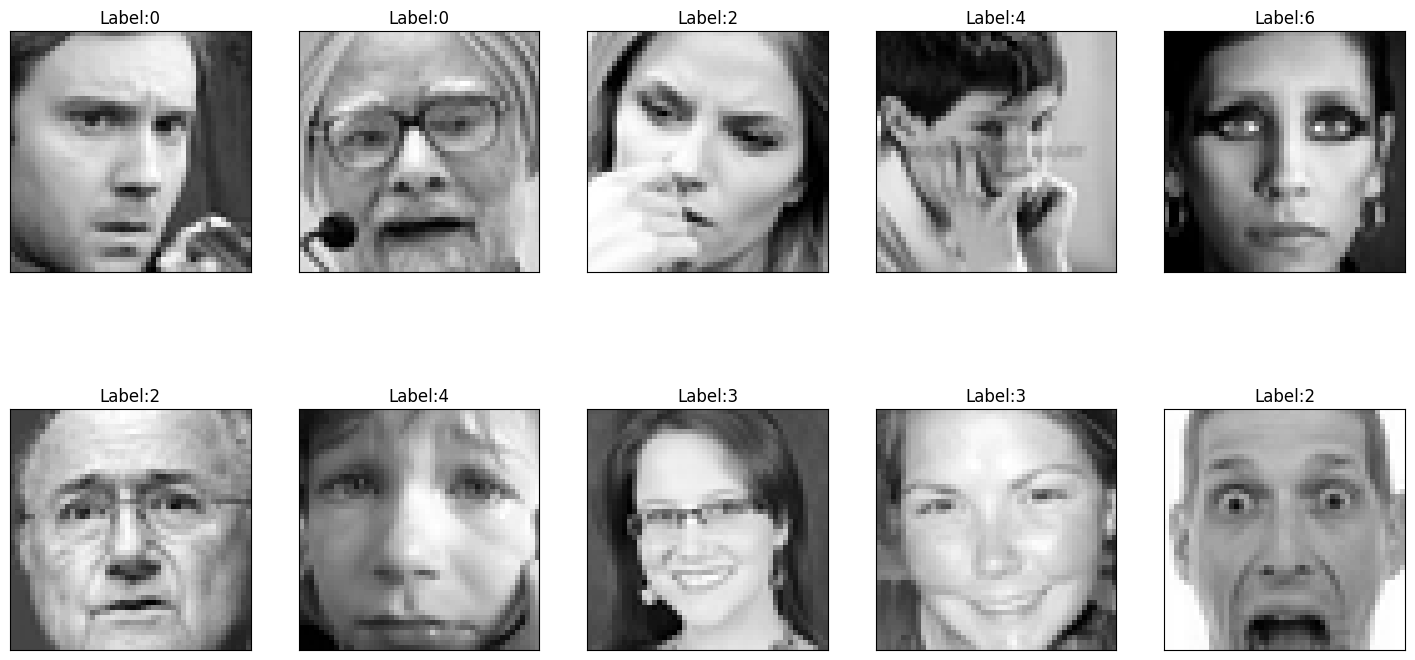

In [91]:
## showing images here
show_img(images, labels)

## Visualize dataset

<Axes: xlabel='emotion'>

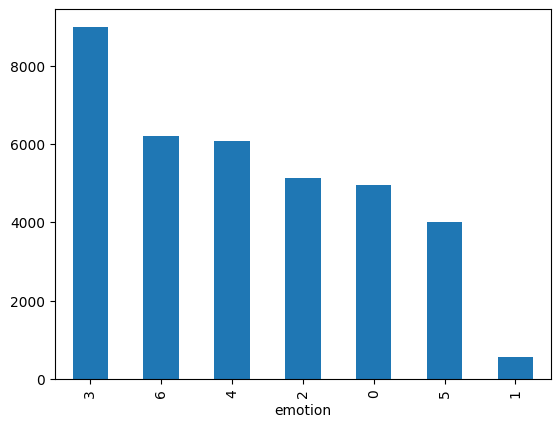

In [83]:
#Visualize the distribution of labels in dataset
df['emotion'].value_counts().plot(kind='bar')

## Normailze data


In [92]:
# Normalize pixel values to be between 0 and 1
images = images / 255.0

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [93]:
from sklearn.decomposition import PCA

# Chuyển đổi các ảnh 48x48 thành các vector 1 chiều
n_samples, height, width = images.shape
X = images.reshape(n_samples, height * width)

# Thực hiện PCA với 2 thành phần chính
pca = PCA(n_components=2)
pca.fit(X)

# Transform dữ liệu để biểu diễn với 2 thành phần chính
images_pca = pca.transform(X)
images_pca.shape

(35887, 2)

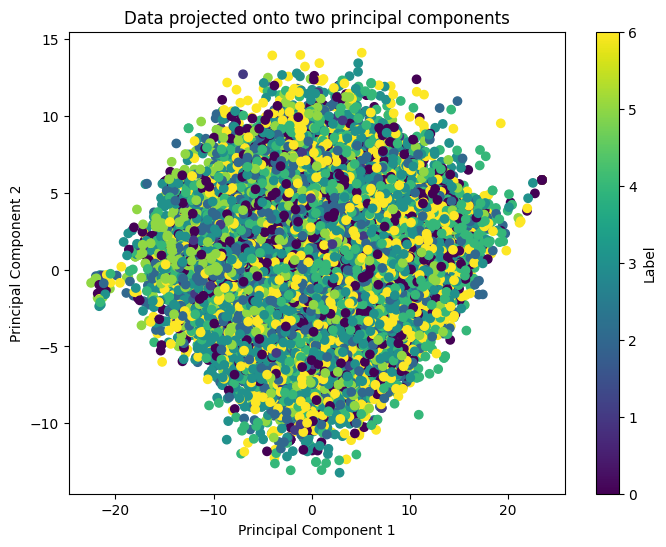

In [94]:
# Biểu diễn dữ liệu sau khi PCA lên 2 thành phần chính
plt.figure(figsize=(8, 6))
scatter = plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Label')
plt.title('Data projected onto two principal components')
plt.show()


Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

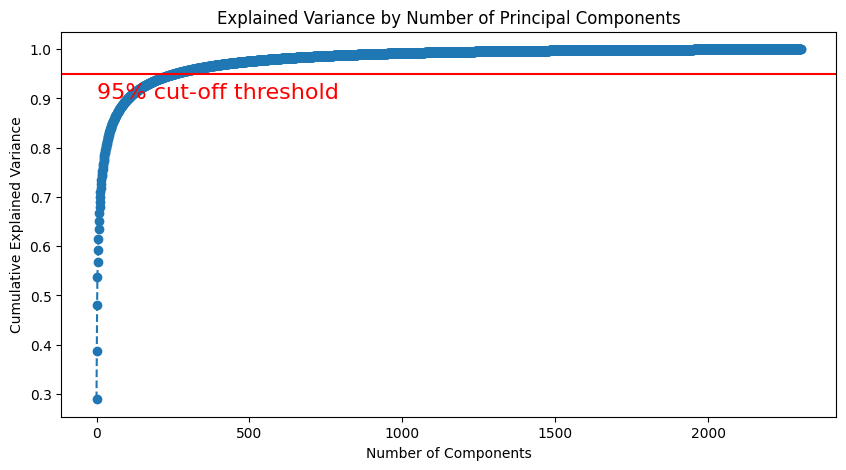

The optimal number of principal components to retain 95% of the variance is: 255


In [95]:
# Thực hiện PCA để xác định số lượng thành phần chính tối ưu
pca_full = PCA()
pca_full.fit(X)

# Hiển thị tỷ lệ phương sai tích lũy
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.9, '95% cut-off threshold', color = 'red', fontsize=16)
plt.show()

# Tìm số lượng thành phần chính để giữ lại 95% phương sai
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)
optimal_components = np.argmax(explained_variance >= 0.95) + 1
print(f'The optimal number of principal components to retain 95% of the variance is: {optimal_components}')


## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

### 3.1 Splitting data tin to train/val/test subsets

In [96]:
## splitting data into train/val/test subsets here

#### 3.1.1 Original data

In [97]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập train (70%) và test (30%)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)

# Tiếp tục chia tập tạm thời (30%) thành validation (15%) và test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))


Train set size: 25120
Validation set size: 5383
Test set size: 5384


In [98]:
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (25120, 48, 48)
y_train shape: (25120,)
X_test shape: (5384, 48, 48)
y_test shape: (5384,)


In [ ]:
#Flatten data
X_train= X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])
X_val=X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
print('X_val aftern fatten',X_val.shape)
print('X_train aftern fatten',X_train.shape)
print('X_train aftern fatten',X_test.shape)

X_val aftern fatten (5383, 2304)
X_train aftern fatten (25120, 2304)
X_train aftern fatten (5384, 2304)


#### 3.1.2 PCA data

In [99]:
from sklearn.model_selection import train_test_split
# Chia dữ liệu thành tập train (70%) và test (30%)
X_PCA_train, X_PCA_temp, y_PCA_train, y_PCA_temp = train_test_split(images_pca, labels, test_size=0.3, random_state=42)

# Tiếp tục chia tập tạm thời (30%) thành validation (15%) và test (15%)
X_PCA_val, X_PCA_test, y_PCA_val, y_PCA_test = train_test_split(X_PCA_temp, y_PCA_temp, test_size=0.5, random_state=42)

print("Train set size:", len(X_PCA_train))
print("Validation set size:", len(X_PCA_val))
print("Test set size:", len(X_PCA_test))


Train set size: 25120
Validation set size: 5383
Test set size: 5384


In [100]:
X_PCA_train.shape

(25120, 2)

In [ ]:
y_PCA_train.shape

(25120,)

#### Scaled data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_PCA_train = scaler.fit_transform(X_PCA_train)
X_PCA_val=scaler.transform(X_PCA_val)
X_PCA_test = scaler.transform(X_PCA_test)

### 3.2 Modeling

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

#### Logistic Regression


In [ ]:
#Define model


def build_model(X, y):
    """
    Design your model and train it (including your best params)
    :param X: feature matrix
    :param y: target
    :return: a model
    """

    # Todo: Input your scaler and logistic model into pipeline
    model=LogisticRegression()
    # Todo: fit your model with X, y
    model.fit(X,y)

    return model


#### Original data

In [ ]:
logreg_model = build_model(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### PCA data

In [ ]:
logreg_PCA_model = build_model(X_PCA_train, y_PCA_train)

#### RandomForestClassifier

In [ ]:
#Define model

def build_model(X, y):
    """
    Design your model and train it (including your best params)
    :param X: feature matrix
    :param y: target
    :return: a model
    """

    # Todo: Input your scaler and logistic model into pipeline
    model=RandomForestClassifier()
    # Todo: fit your model with X, y
    model.fit(X,y)

    return model


##### Original data

In [ ]:
ranfor_model=build_model(X_train, y_train)

##### PCA data

In [ ]:
ranfor_PCA_model=build_model(X_PCA_train, y_PCA_train)

#### Support Vector Machine

In [ ]:
#Define model

def build_model(X, y):
    """
    Design your model and train it (including your best params)
    :param X: feature matrix
    :param y: target
    :return: a model
    """

    # Todo: Input your scaler and logistic model into pipeline
    model=SVC()
    # Todo: fit your model with X, y
    model.fit(X,y)

    return model

##### Original data

In [ ]:
svc_model=build_model(X_train, y_train)

##### PCA data

In [ ]:
svc_PCA_model=build_model(X_PCA_train, y_PCA_train)

#### **MLP**

In [ ]:
#Define model
from sklearn.neural_network import MLPClassifier

MLP_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=101)

##### Original data

In [ ]:
MLP_clf.fit(X_train, y_train)

MLPClassifier(max_iter=300, random_state=101)

##### PCA data

In [ ]:
MLP_PCA_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=41)

MLP_PCA_clf.fit(X_PCA_train, y_PCA_train)

MLPClassifier(max_iter=300, random_state=41)

#### Model Performance

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Hàm huấn luyện và lưu kết quả các metric vào CSV
def save_model_metrics(models, X_test, y_test, output_file):
    results = []

    for name, model in models.items():
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred, output_dict=True)

        # In kết quả ra màn hình
        print(f"Model: {name}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")
        print("Confusion Matrix:\n", cm)
        print("Classification Report:\n", classification_report(y_test, y_pred))

        # Chuẩn bị dữ liệu để lưu vào DataFrame
        result = {
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': cm.tolist()
        }

        # Thêm các giá trị từ classification report vào kết quả
        for key in cr:
            if isinstance(cr[key], dict):
                for metric in cr[key]:
                    result[f'{key} {metric}'] = cr[key][metric]
            else:
                result[key] = cr[key]

        results.append(result)

    # Chuyển kết quả thành DataFrame
    results_df = pd.DataFrame(results)
    # Lưu DataFrame vào file CSV
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")


models = {
    'Logistic Regression': logreg_model,
    'Random Forest': ranfor_model,
    'Support Vector Machine': svc_model,
    'MLP': MLP_clf
}

PCA_models = {
    'Logistic Regression PCA': logreg_PCA_model,
    'Random Forest PCA': ranfor_PCA_model,
    'Support Vector Machine PCA': svc_PCA_model,
    'MLP PCA': MLP_PCA_clf
}


# Lưu kết quả các metric của các mô hình vào file CSV
save_model_metrics(models, X_test, y_test, '/content/drive/MyDrive/Intro ML/Mini Project/data/result.csv')
save_model_metrics(PCA_models, X_PCA_test, y_PCA_test, '/content/drive/MyDrive/Intro ML/Mini Project/data/result_PCA.csv')


Model: Logistic Regression, Accuracy: 0.3475111441307578, Precision: 0.3359881047610834, Recall: 0.3475111441307578, F1: 0.3372522239306943
Confusion Matrix:
 [[140   4  77 195 147  47 124]
 [  8   5  14  19  15   8  11]
 [ 93   2 139 168 133  87 140]
 [116   1 112 770 146  43 147]
 [107   1  93 235 242  40 188]
 [ 37   1  64  98  58 264  81]
 [ 94   1  77 237 193  51 311]]
Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.19      0.21       734
           1       0.33      0.06      0.11        80
           2       0.24      0.18      0.21       762
           3       0.45      0.58      0.50      1335
           4       0.26      0.27      0.26       906
           5       0.49      0.44      0.46       603
           6       0.31      0.32      0.32       964

    accuracy                           0.35      5384
   macro avg       0.33      0.29      0.30      5384
weighted avg       0.34      0.35      0.34      5384

Mo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

Model: Logistic Regression PCA, Accuracy: 0.2540861812778603, Precision: 0.1578686952906447, Recall: 0.2540861812778603, F1: 0.15036802830907348
Confusion Matrix:
 [[   0    0    3  602  100   29    0]
 [   0    0    2   68    6    4    0]
 [   0    0    3  632   82   45    0]
 [   0    0    1 1142  128   64    0]
 [   0    0    2  738  148   18    0]
 [   0    0    3  487   38   75    0]
 [   0    0    4  788  148   24    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       734
           1       0.00      0.00      0.00        80
           2       0.17      0.00      0.01       762
           3       0.26      0.86      0.39      1335
           4       0.23      0.16      0.19       906
           5       0.29      0.12      0.17       603
           6       0.00      0.00      0.00       964

    accuracy                           0.25      5384
   macro avg       0.13      0.16      0.11      5384
wei

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [ ]:
result = pd.read_csv('/content/drive/MyDrive/Intro ML/Mini Project/data/result.csv')
result

,Model,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,0 precision,0 recall,0 f1-score,0 support,...,6 support,accuracy,macro avg precision,macro avg recall,macro avg f1-score,macro avg support,weighted avg precision,weighted avg recall,weighted avg f1-score,weighted avg support
0,Logistic Regression,0.347511,0.335988,0.347511,0.337252,"[[140, 4, 77, 195, 147, 47, 124], [8, 5, 14, 1...",0.235294,0.190736,0.210685,734,...,964,0.347511,0.330781,0.291423,0.295550,5384,0.335988,0.347511,0.337252,5384
1,Random Forest,0.453566,0.466594,0.453566,0.435414,"[[153, 0, 52, 276, 139, 23, 91], [7, 20, 4, 27...",0.423823,0.208447,0.279452,734,...,964,0.453566,0.547885,0.401665,0.425566,5384,0.466594,0.453566,0.435414,5384
2,Support Vector Machine,0.455795,0.459283,0.455795,0.438533,"[[174, 0, 54, 212, 158, 30, 106], [10, 6, 10, ...",0.418269,0.237057,0.302609,734,...,964,0.455795,0.534091,0.379987,0.389314,5384,0.459283,0.455795,0.438533,5384
3,MLP,0.391716,0.395245,0.391716,0.392179,"[[238, 12, 103, 127, 132, 34, 88], [18, 23, 9,...",0.279671,0.324251,0.300315,734,...,964,0.391716,0.373863,0.374154,0.372869,5384,0.395245,0.391716,0.392179,5384


In [ ]:
result_PCA = pd.read_csv('/content/drive/MyDrive/Intro ML/Mini Project/data/result_PCA.csv')
result_PCA

,Model,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,0 precision,0 recall,0 f1-score,0 support,...,6 support,accuracy,macro avg precision,macro avg recall,macro avg f1-score,macro avg support,weighted avg precision,weighted avg recall,weighted avg f1-score,weighted avg support
0,Logistic Regression PCA,0.254086,0.157869,0.254086,0.150368,"[[0, 0, 3, 602, 100, 29, 0], [0, 0, 2, 68, 6, ...",0.000000,0.000000,0.000000,734,...,964,0.254086,0.134309,0.163872,0.109468,5384,0.157869,0.254086,0.150368,5384
1,Random Forest PCA,0.254086,0.252244,0.254086,0.251930,"[[142, 3, 97, 216, 114, 56, 106], [8, 15, 7, 2...",0.201991,0.193460,0.197634,734,...,964,0.254086,0.266738,0.242242,0.250165,5384,0.252244,0.254086,0.251930,5384
2,Support Vector Machine PCA,0.257429,0.272412,0.257429,0.157146,"[[2, 0, 10, 592, 80, 44, 6], [0, 0, 0, 66, 3, ...",0.500000,0.002725,0.005420,734,...,964,0.257429,0.240871,0.168663,0.117198,5384,0.272412,0.257429,0.157146,5384
3,MLP PCA,0.255944,0.182093,0.255944,0.153375,"[[0, 0, 0, 604, 57, 67, 6], [0, 0, 0, 64, 3, 1...",0.000000,0.000000,0.000000,734,...,964,0.255944,0.147542,0.170630,0.115195,5384,0.182093,0.255944,0.153375,5384


In [ ]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Function plot confusion matrix
def plot_confusion_matrix(model_name,df):
    """
    Plots the confusion matrix for a given model.

    Parameters:
    model_name (str): The name of the model to plot the confusion matrix for.

    Returns:
    None
    """
    # Find the row corresponding to the given model name
    row = df[df['Model'] == model_name]

    if row.empty:
        print(f"Model '{model_name}' not found.")
        return

    # Extract the confusion matrix string
    confusion_matrix_str = row['Confusion Matrix'].values[0]

    # Convert the string representation of the confusion matrix to a Python list
    confusion_matrix = ast.literal_eval(confusion_matrix_str)

    # Convert the list to a NumPy array
    confusion_matrix = np.array(confusion_matrix)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

## Logistic Regression


### Original data

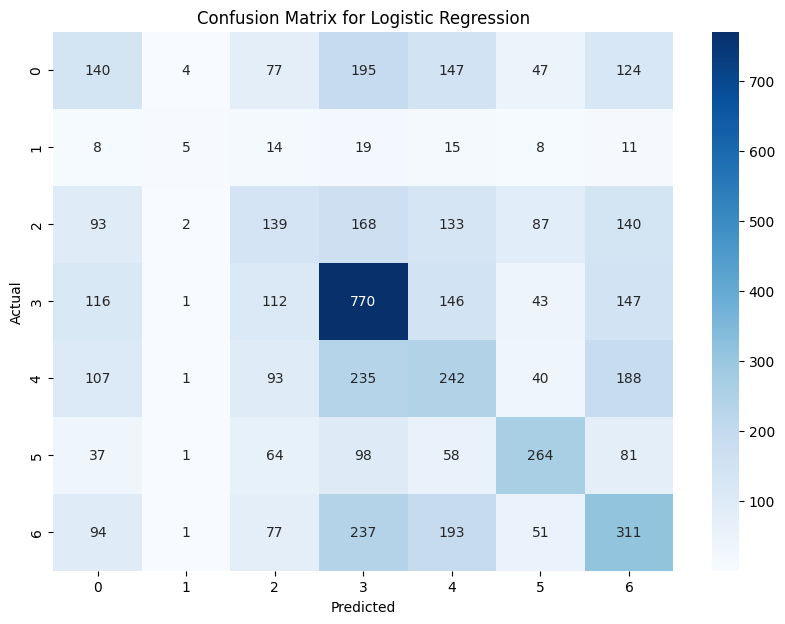

In [ ]:
plot_confusion_matrix('Logistic Regression',result)

* The emotion category that the model predicts most accurately is: **3 - Happy**
* The emotion category that the model predicts most incorrectly is: **1 - Disgust**


### PCA data

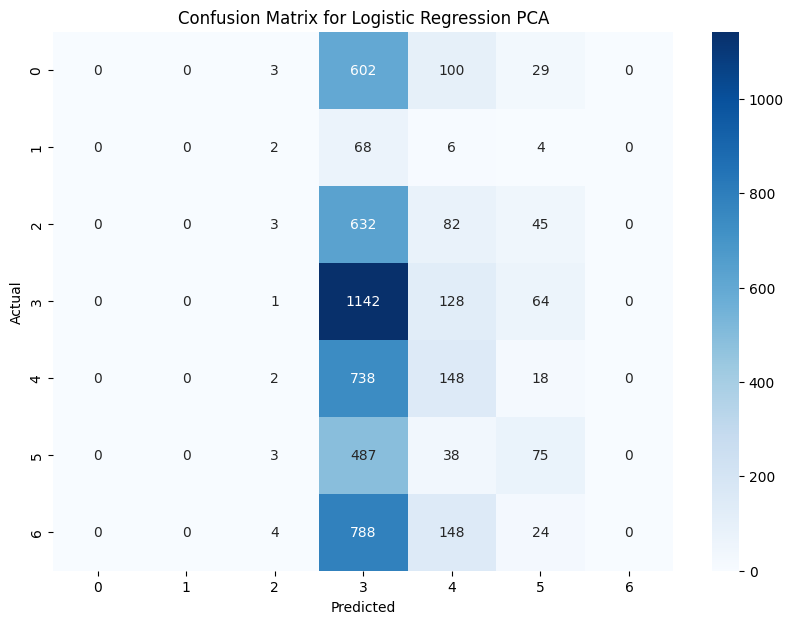

In [ ]:
plot_confusion_matrix('Logistic Regression PCA',result_PCA)

* The emotion category that the model predicts most accurately is: **3 - Happy**
* The model's prediction
 results are mostly inaccurate but focus on **(3-happy)**. This is a sign that model is overfitting with the label **(3-happy)**.


## Random Forest

### Original data

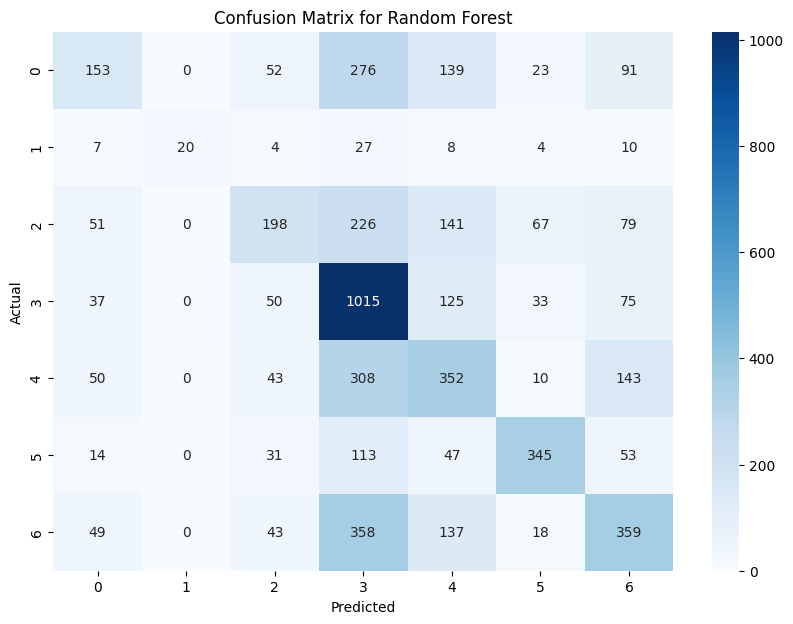

In [ ]:
plot_confusion_matrix('Random Forest',result)

* The emotion category that the model predicts most accurately is: **3 - Happy**
* The emotion category that the model predicts most incorrectly is: **1 - Disgust**

### PCA data

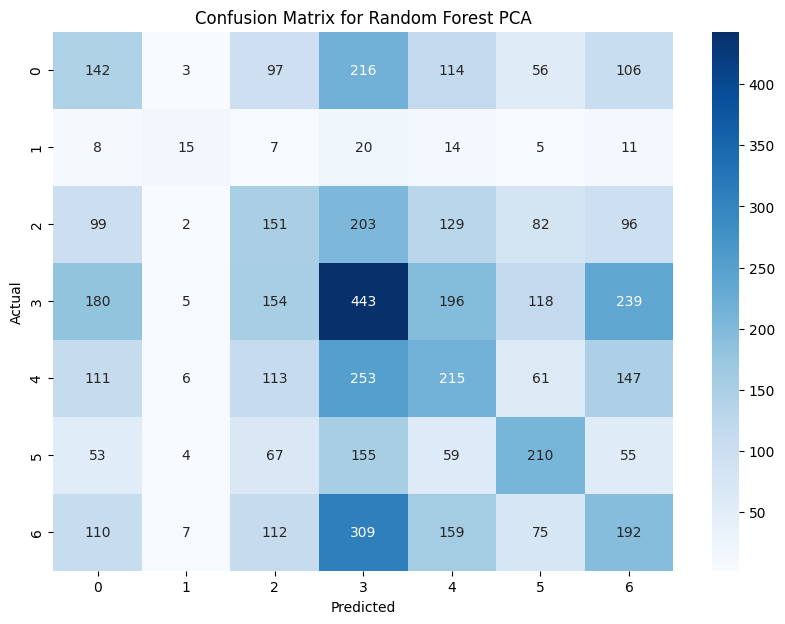

In [ ]:
plot_confusion_matrix('Random Forest PCA',result_PCA)

* The emotion category that the model predicts most accurately is: **3 - Happy**
* The model's prediction
 results are mostly inaccurate but focus on **(3-happy)**. This is a sign that model is overfitting with the label **(3-happy)**.


## Support vector Machine

### Original data

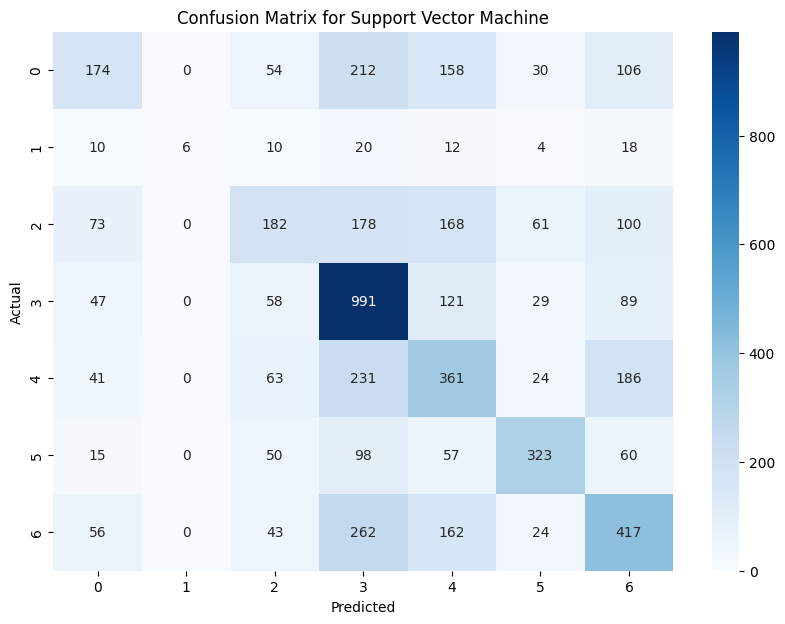

In [ ]:
plot_confusion_matrix('Support Vector Machine',result)

* The emotion category that the model predicts most accurately is: **3 - Happy**
* The emotion category that the model predicts most incorrectly is: **1 - Disgust**

### PCA data

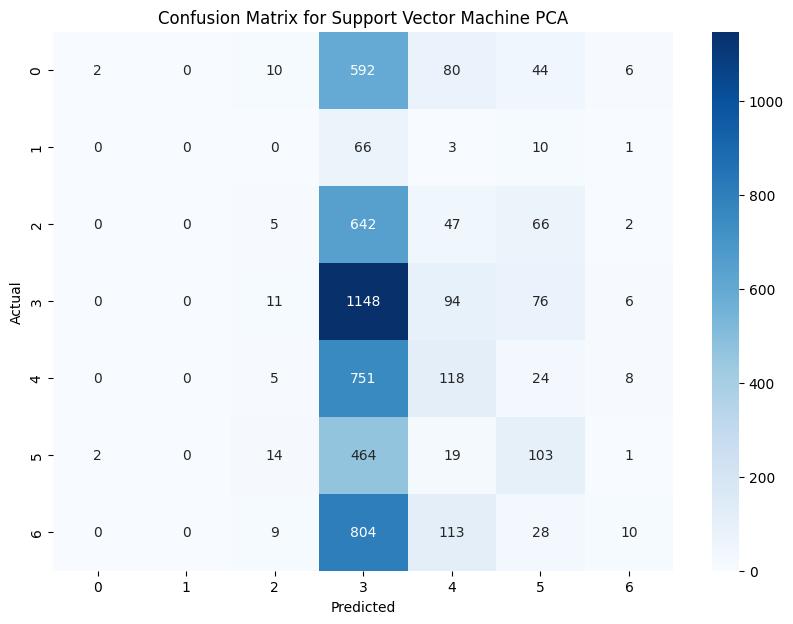

In [ ]:
plot_confusion_matrix('Support Vector Machine PCA',result_PCA)

* The emotion category that the model predicts most accurately is: **3 - Happy**
* The model's prediction
 results are mostly inaccurate but focus on **(3-happy)**. This is a sign that model is overfitting with the label **(3-happy)**.


## MLP

### Original data

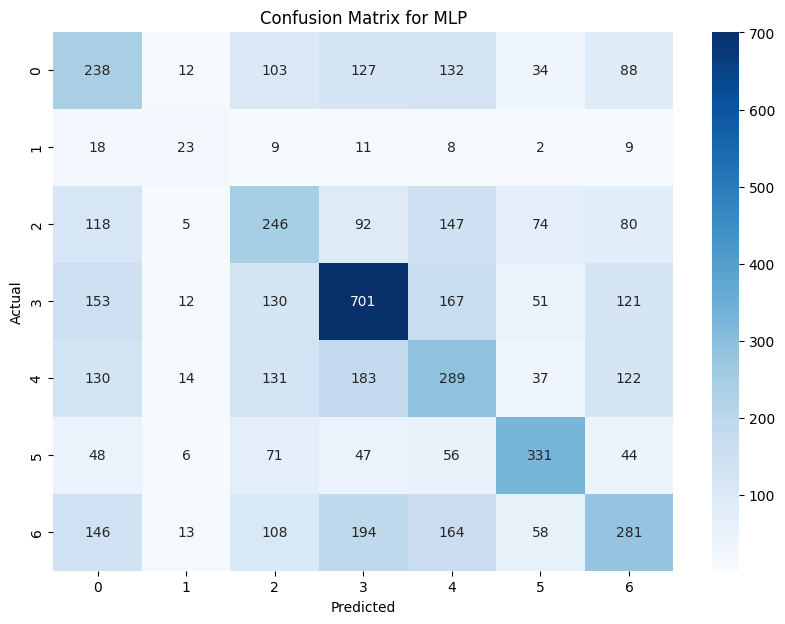

In [ ]:
plot_confusion_matrix('MLP',result)

* The emotion category that the model predicts most accurately is: **3 - Happy**
* The emotion category that the model predicts most incorrectly is: **1 - Disgust**

### PCA data

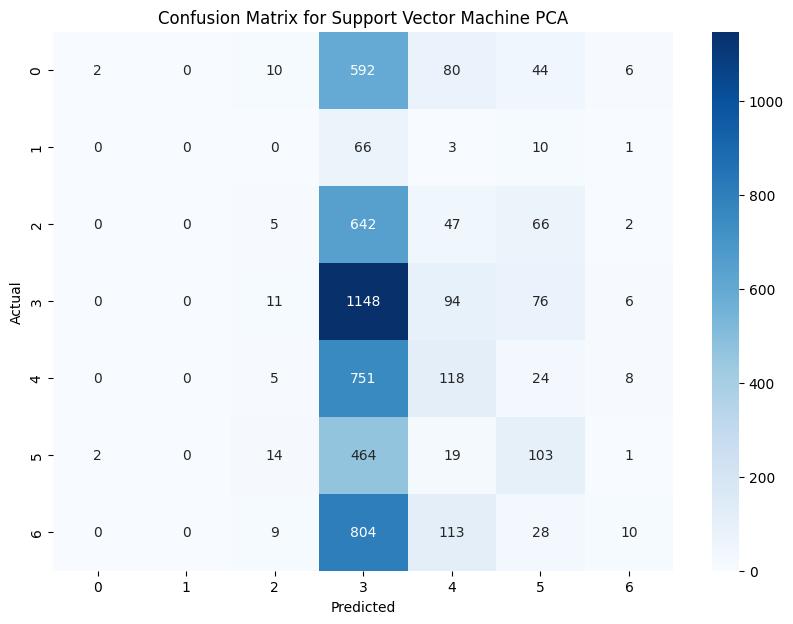

In [ ]:
plot_confusion_matrix('Support Vector Machine PCA',result_PCA)

* The emotion category that the model predicts most accurately is: **3 - Happy**
* The model's prediction
 results are mostly inaccurate but focus on **(3-happy)**. This is a sign that model is overfitting with the label **(3-happy)**.



Overall, it has been observed that the performance of the same model using PCA-processed data is noticeably worse than using original data. This can be attributed to several factors:

1. Data Loss: PCA inherently results in data loss, implying that the model trained on PCA-processed data receives less information compared to using original data.

2. Aggravated Class Imbalance: If the original data is already imbalanced between classes, employing PCA further exacerbates the imbalance. This can lead to significant overfitting in all models utilizing PCA-processed data.

## Overall


In [ ]:
## visualize the confusion matrices and classification reports here

<Axes: ylabel='count'>

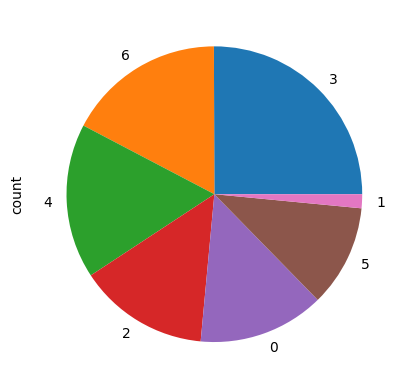

In [ ]:
df['emotion'].value_counts().plot(kind='pie')

In [ ]:
metrics_df = result[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.347511,0.335988,0.347511,0.337252
1,Random Forest,0.453566,0.466594,0.453566,0.435414
2,Support Vector Machine,0.455795,0.459283,0.455795,0.438533
3,MLP,0.391716,0.395245,0.391716,0.392179


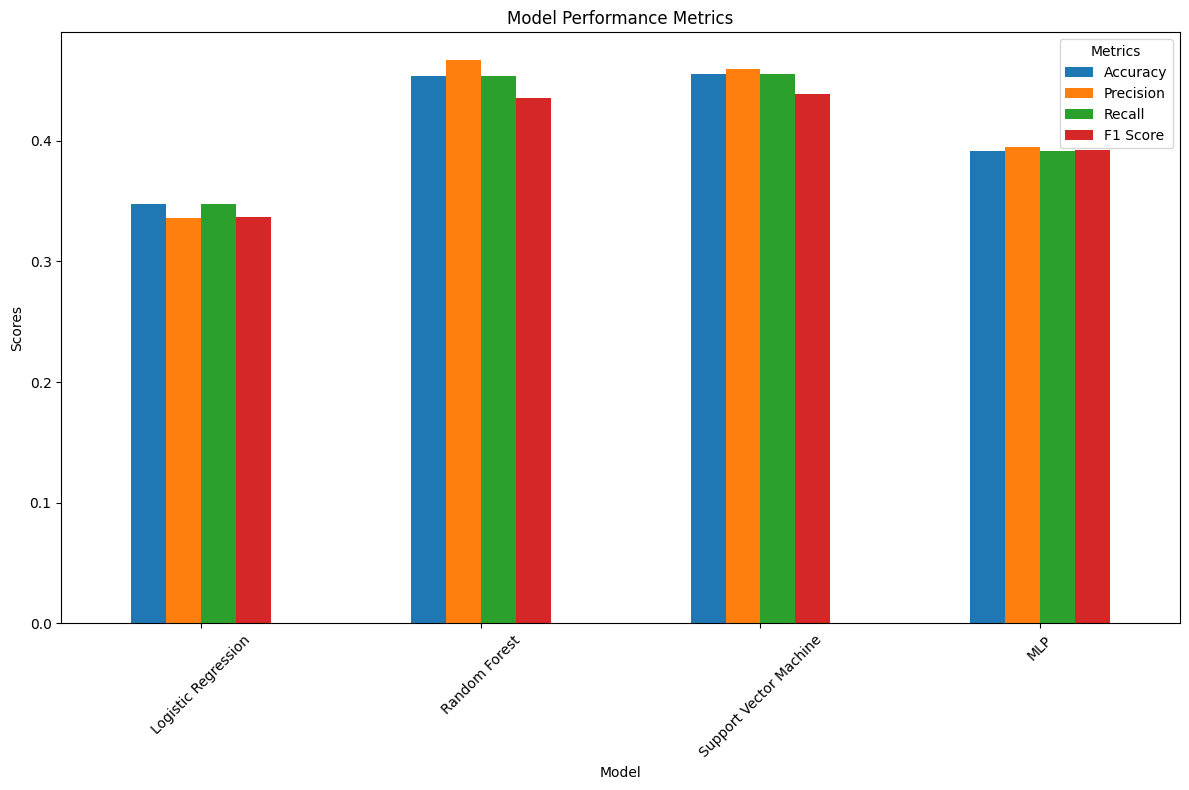

In [ ]:
metrics_df.set_index('Model').plot(kind='bar', figsize=(12, 8))

# Add title and labels
plt.title('Model Performance Metrics')
plt.xlabel('Model')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.legend(title='Metrics')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
metrics_PCA_df = result_PCA[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]
metrics_PCA_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression PCA,0.254086,0.157869,0.254086,0.150368
1,Random Forest PCA,0.254086,0.252244,0.254086,0.251930
2,Support Vector Machine PCA,0.257429,0.272412,0.257429,0.157146
3,MLP PCA,0.255944,0.182093,0.255944,0.153375


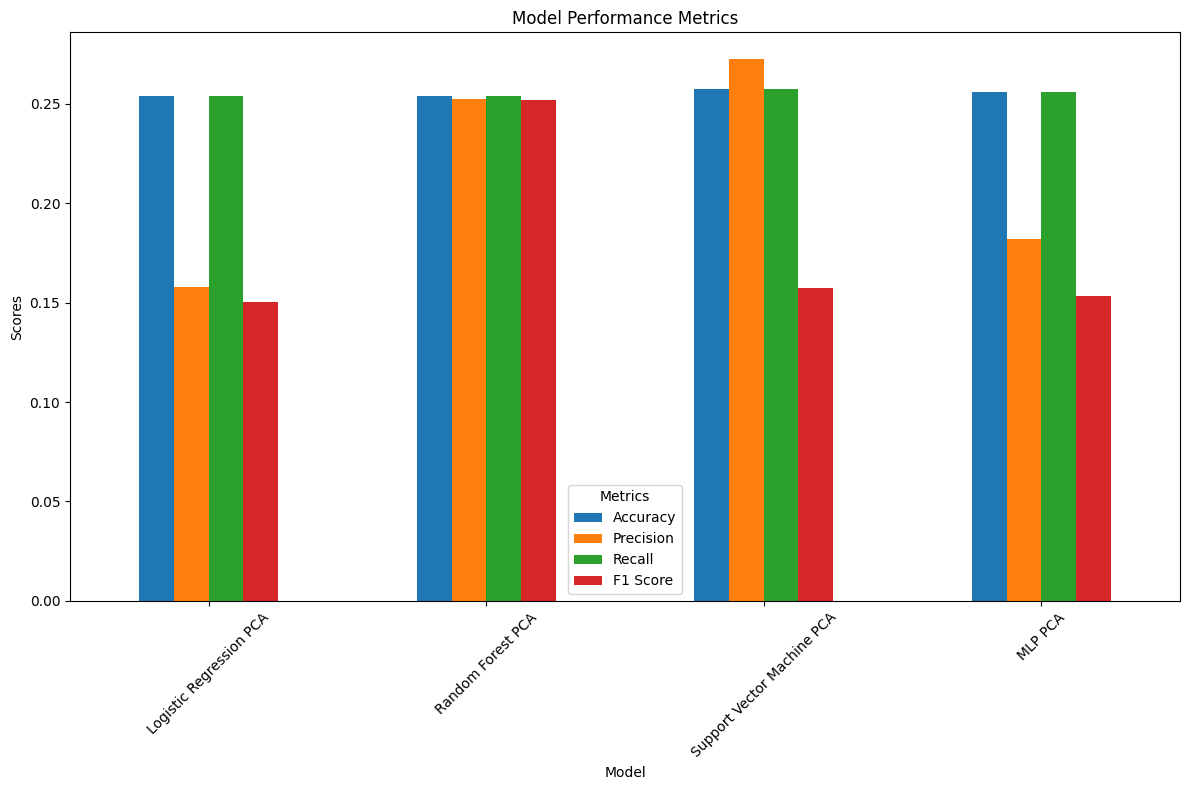

In [ ]:
metrics_PCA_df.set_index('Model').plot(kind='bar', figsize=(12, 8))

# Add title and labels
plt.title('Model Performance Metrics')
plt.xlabel('Model')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.legend(title='Metrics')

# Display the plot
plt.tight_layout()
plt.show()

1. **Weighted average** is a metric used to evaluate a classification model's overall performance. It is calculated by taking the average of the model's accuracy for each class, with the weights being the proportion of that class in the dataset. This is useful when the classes in the dataset are imbalanced, as it takes into account the fact that some classes are more important than others. That's the reason for team used **weighted average** to compare all the models together.

2. **The confusion matrix** illustrates the number of correctly and incorrectly classified instances for each class in the dataset

3. Overall, Random Forest and SVM demonstrate superior performance compared to other models across **accuracy, recall, precision, and F1 score**. Notably, Random Forest maintains more consistent results in all four metrics compared to SVM.

Based on the following criteria to evaluate model performance we can conclude the best model in this case is **Random Forest Classifier**
  